# Flyer Agent

Notes:
state_prime is next state

In [1]:
# !pip install tqdm
# ! pip install gym

In [2]:
import tensorflow as tf
import numpy as np
import random
import gym
import tqdm

import Flyer_Agent_Environment as FAE
slim = tf.contrib.slim

#%matplotlib inline 
%matplotlib notebook 

In [3]:
def calculate_naive_returns(rewards):
    """ Calculates a list of naive returns given a 
    list of rewards."""
    total_returns = np.zeros(len(rewards))
    total_return = 0.0
    for t in range(len(rewards), -1, -1): # changed end index to -1 RL
        total_return = total_return + rewards[t] # also fixed
        total_returns[t] = total_return
    return total_returns

In [4]:
def discount_rewards(rewards, gamma=0.99):
    discounted_returns = [0 for _ in rewards]
    discounted_returns[-1] = rewards[-1]
    for t in range(len(rewards)-2, -1, -1): # iterate backwards
        discounted_returns[t] = rewards[t] + discounted_returns[t+1]*gamma
    return discounted_returns

In [5]:
def epsilon_greedy_action(action_distribution, epsilon=1e-1):
    if random.random() < epsilon:
        return np.argmax(np.random.random(
           action_distribution.shape))
    else:
        return np.argmax(action_distribution)

In [6]:
def epsilon_greedy_action_annealed(action_distribution,
                                   percentage, 
                                   epsilon_start=1.0, 
                                   epsilon_end=1e-2):
    annealed_epsilon = epsilon_start*(1.0-percentage) + epsilon_end*percentage
    if random.random() < annealed_epsilon:
        return np.argmax(np.random.random(
          action_distribution.shape))
    else:
        return np.argmax(action_distribution)


In [7]:
# this is about single episodes
class EpisodeHistory(object):

    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.state_primes = []
        self.discounted_returns = []

    def add_to_history(self, state, action, reward, 
      state_prime):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.state_primes.append(state_prime)


In [8]:
# this holds multiple episodes
class Memory(object):

    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.state_primes = []
        self.discounted_returns = []

    def reset_memory(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.state_primes = []
        self.discounted_returns = []

    def add_episode(self, episode):
        self.states += episode.states
        self.actions += episode.actions
        self.rewards += episode.rewards
        self.discounted_returns += episode.discounted_returns

In [9]:
class PGAgent(object):

    def __init__(self, session, state_size, num_actions,
        hidden_size, learning_rate=1e-3, 
        explore_exploit_setting=
          'epsilon_greedy_annealed_1.0->0.001'):
        self.session = session
        self.state_size = state_size
        self.num_actions = num_actions
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.explore_exploit_setting = explore_exploit_setting

        self.build_model()
        self.build_training()

    def build_model(self):
        with tf.variable_scope('pg-model'):
            self.state = tf.placeholder(
                shape=[None, self.state_size], 
                dtype=tf.float32)
            self.h0 = slim.fully_connected(self.state, 
            self.hidden_size)
            self.h1 = slim.fully_connected(self.h0, 
            self.hidden_size)
#             self.output = slim.fully_connected(
#                 self.h1, self.num_actions, 
#                 activation_fn=tf.nn.softmax)
#             # more hidden layers
            self.h2 = slim.fully_connected(self.h1, 
            self.hidden_size)
            self.h3 = slim.fully_connected(self.h2, 
            self.hidden_size)
            self.h4 = slim.fully_connected(self.h3, 
            self.hidden_size)
            self.output = slim.fully_connected(
                self.h4, self.num_actions, 
                activation_fn=tf.nn.softmax)

    def build_training(self):
        self.action_input = tf.placeholder(tf.int32, 
          shape=[None])
        self.reward_input = tf.placeholder(tf.float32, 
          shape=[None])

        # Select the logits related to the action taken
# this creates list of indices ?(ie num samples) long that are at start of each row in one-hot - then 
# adds indexes into each row of
# particular pre-selected action
        self.output_index_for_actions = (tf.range(
            0, tf.shape(self.output)[0]) * 
              tf.shape(self.output)[1]) + self.action_input
# then this flattens everything into 1-D, then selects from it using those indices
# all of this is a way to select only the neuron outputs that correspond to just the actions taken, rather
# than getting the values for all actions
        self.logits_for_actions = tf.gather(
            tf.reshape(self.output, [-1]), 
            self.output_index_for_actions)

        self.loss = -tf.reduce_mean(tf.log(tf.clip_by_value(self.logits_for_actions,1e-10,1.0)) * 
              self.reward_input)
# see book pg. 254
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate)
        self.train_step = self.optimizer.minimize(self.loss)

    def sample_action_from_distribution(
      self, action_distribution, 
      epsilon_percentage):
        # Choose an action based on the action probability 
        # distribution and an explore vs exploit
        if self.explore_exploit_setting == 'greedy':
            action = greedy_action(action_distribution)
        elif self.explore_exploit_setting == 'epsilon_greedy_0.05':
            action = epsilon_greedy_action(action_distribution,
              0.05)
        elif self.explore_exploit_setting == 'epsilon_greedy_0.25':
            action = epsilon_greedy_action(action_distribution, 
              0.25)
        elif self.explore_exploit_setting == 'epsilon_greedy_0.50':
            action = epsilon_greedy_action(action_distribution, 
              0.50)
        elif self.explore_exploit_setting == 'epsilon_greedy_0.90':
            action = epsilon_greedy_action(action_distribution, 
              0.90)
        elif self.explore_exploit_setting == 'epsilon_greedy_annealed_1.0->0.001':
            action = epsilon_greedy_action_annealed(
                action_distribution, epsilon_percentage, 1.0, 
                  0.001)
        elif self.explore_exploit_setting == 'epsilon_greedy_annealed_0.5->0.001':
            action = epsilon_greedy_action_annealed(
                action_distribution, epsilon_percentage, 0.5, 
                  0.001)
        elif self.explore_exploit_setting == 'epsilon_greedy_annealed_0.25->0.001':
            action = epsilon_greedy_action_annealed(
                action_distribution, epsilon_percentage, 0.25,
                  0.001)

        return action

    def predict_action(self, state, epsilon_percentage):
        action_distribution = self.session.run(
            self.output, feed_dict={self.state: [state]})#[0]
#         print('action dist',action_distribution)
        action = self.sample_action_from_distribution(
            action_distribution, epsilon_percentage)
        return action
    
    def show_current_policy(self):
        # Evaluate Current Policy - No Epsilon ------------------------------------
        pol_ep_hist = EpisodeHistory()
        state = env.reset()
        e_p = 1.0 # result in using end epsilon
        for n in range(20):    # figure out next action
            action = agent.predict_action(state, \
              e_p)
            # take a step
            state_prime, reward, terminal, _ = env.step(action)
            state = state_prime
            pol_ep_hist.add_to_history(state, action, reward, state_prime)
        print('Policy Actions - No Epsilon')
        print(pol_ep_hist.actions)


In [10]:
# def main():
# Configure Settings
total_episodes = 2000
epsilon_stop = 0.6*total_episodes#3000
BATCH_SIZE = 10 # this is the number of episodes generated before we train
MAX_EP_LENGTH = 199 #Fixed by env in Open AI Gym (we think)
render_start = False #-1
should_render = False # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LEARNING_RATE = 1e-2
HIDDEN_SIZE = 16

explore_exploit_setting = 'epsilon_greedy_annealed_1.0->0.001'
env = gym.make('CartPole-v0')
state_size = env.observation_space.shape[0]  # 4 for CartPole-v0
num_actions = env.action_space.n  # 2 for CartPole-v0
# env = FAE.FlyerAgentEnv()
# state_size = 4  
# num_actions = 9

solved = False
batch_flag = False
num_episodes = 0

with tf.Session() as session:
    agent = PGAgent(session=session, state_size=state_size,
      num_actions=num_actions,
                    hidden_size=HIDDEN_SIZE, learning_rate = LEARNING_RATE,
                      explore_exploit_setting=
                        explore_exploit_setting)
    session.run(tf.global_variables_initializer())

    episode_rewards = []
    episode_terminal = [] # 1 for success, -1 for failure (o.b.)
    episode_steps = []
    episode_maxs = []
    batch_losses = []

    global_memory = Memory()
    steps = 0 # total number of steps in all episodes
    for i in tqdm.tqdm(range(total_episodes)): # multiple episode loop
        state = env.reset()
        episode_reward = 0.0 # cumulative sum of all rewards in episode
        episode_history = EpisodeHistory()
        epsilon_percentage = min(i/float(
          epsilon_stop), 1.0)
        steps_this_ep = 0
        terminal = False
        j = 0 # num steps in episode
        while (j < MAX_EP_LENGTH) and (not terminal): # play single episode ------------------
        #for j in range(MAX_EP_LENGTH):
            j += 1
            # figure out next action
            action = agent.predict_action(state, 
              epsilon_percentage)
            # take a step
            # Note: action is not one-hot yet - it's a scalar
            state_prime, reward, terminal, _ = env.step(action)
            
            if (render_start > 0 and i > 
              render_start and should_render) \
                or (solved and should_render):
                env.render()
            episode_history.add_to_history(
                state, action, reward, state_prime)
            episode_reward += reward
            steps += 1
            steps_this_ep += 1
            # advance the state
            state = state_prime
            
#         print('number of steps in episode', j)  
        episode_history.discounted_returns = discount_rewards(episode_history.rewards)
        
#         # this is a modification that attempts to enhance the rewards for "good" episodes
#         # it doesn't seem to hurt - need more experimentation to know if it helps
#         for nn in range(len(episode_history.discounted_returns)):
#             episode_history.discounted_returns[nn] *= (1+(steps_this_ep/MAX_EP_LENGTH))**2

        global_memory.add_episode(episode_history)
        episode_rewards.append(episode_reward)
        # save sum of rewards, num_steps of this episode
        episode_steps.append(steps_this_ep)
        episode_maxs.append(max(episode_history.rewards))
        episode_terminal.append(terminal)

        num_episodes += 1

        # if we completed a minibatch then train
        if np.mod(i, BATCH_SIZE) == 0:
            feed_dict = {
            agent.reward_input: np.array(
              global_memory.discounted_returns),
            agent.action_input: np.array(
              global_memory.actions), 
            agent.state: np.array(
              global_memory.states)}
            _, batch_loss = session.run(
                [agent.train_step, agent.loss],
                  feed_dict=feed_dict)
            batch_losses.append(batch_loss)
            global_memory.reset_memory()
            
#             agent.show_current_policy()
            
#             if i > 1:
#                 batch_flag = True

#         #delete this
#         if terminal == 0 or batch_flag or num_episodes == 50:
#             print('terminal ',terminal,' batch_flag ',batch_flag)
#             break

#         if i % 10: # show results every 10th iteration
#             if np.mean(episode_rewards[:]) > 100.0:
#                 solved = True
#             else:
#                 solved = False
#     print('Solved:', solved, 'Mean Reward', np.mean(episode_rewards[:-100]))
    
    print('Num episodes:',num_episodes)
    
    print('Final Mean Reward - last 100', np.mean(episode_rewards[-100:-1]))
        
    print('Final Run - with Epsilon')
    print(episode_history.actions)
    
    
    print('Final Policy - No Epsilon')
    env.reset()
    e_p = 1.0 # so use end epsilon
    for n in range(20):    # figure out next action
        action = agent.predict_action(state, \
          e_p)
        # take a step
        state_prime, reward, terminal, _ = env.step(action)
        state = state_prime
        print(state_prime,action,reward)  
        # NOTE: doesn't terminate with done flag

/home/johnnybravo/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
100%|██████████| 2000/2000 [01:08<00:00, 29.35it/s]

Num episodes: 2000
Final Mean Reward - last 100 33.0404040404
Final Run - with Epsilon
[1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0]
Final Policy - No Epsilon
[-0.04946979 -0.2075801   0.03028761  0.34061783] 0 1.0
[-0.05362139 -0.01290188  0.03709997  0.05763764] 1 1.0
[-0.05387943  0.18166902  0.03825272 -0.22311299] 1 1.0
[-0.05024605  0.37622394  0.03379046 -0.50348833] 1 1.0
[-0.04272157  0.18064245  0.02372069 -0.20035105] 0 1.0
[-0.03910872  0.37541725  0.01971367 -0.48545783] 1 1.0
[-0.03160037  0.18002273  0.01000452 -0.18662757] 0 1.0
[-0.02799992  0.37500013  0.00627197 -0.47613774] 1 1.0
[-0.02049992  0.17979018 -0.00325079 -0.18148463] 0 1.0
[-0.01690411  0.37495849 -0.00688048 -0.47519129] 1 1.0
[-0.00940494  0.17993438 -0.01638431 -0.18468488] 0 1.0
[-0.00580626  0.37528688 -0.02007801 -0.48249108] 1 1.0
[ 0.00169948  0.18045398 -0.02972783 -0.19620318] 0 1.0
[ 0.00530856  0.37598827 -0.03365189 -0.4981137 ] 1 1.0
[ 0.01282833  0.18135

In [11]:
# main()

In [12]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


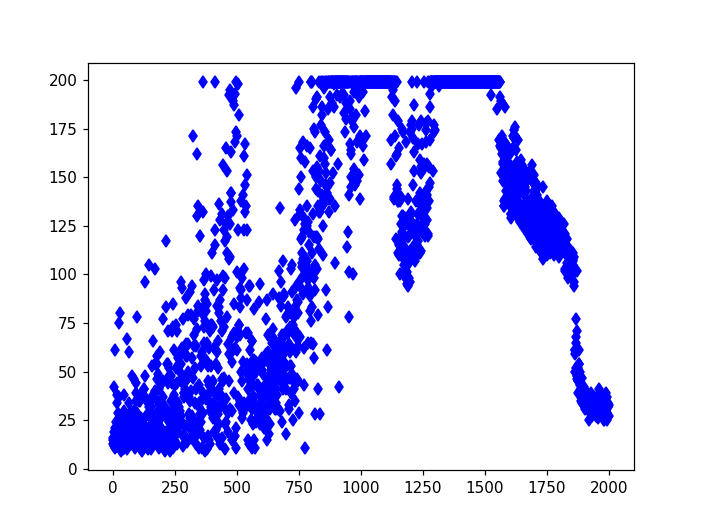

In [13]:
plt.figure()
plt.plot(episode_rewards,'bd')

In [14]:
    print('Final Mean Reward - last 100', np.mean(episode_rewards[-100:-1]))

Final Mean Reward - last 100 33.0404040404


<IPython.core.display.Javascript object>


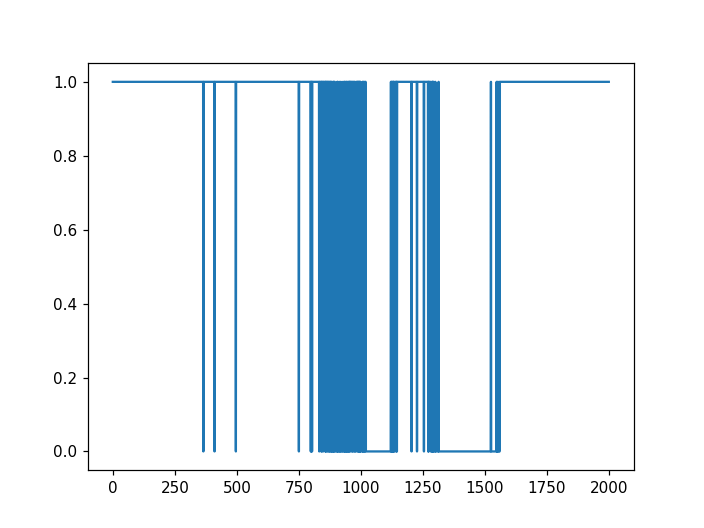

In [15]:
plt.figure()
plt.plot(episode_terminal)